# Exploring Oura ring data

In [2]:
#%pip install pandas mlplot
 
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter


## First, let's grab data from local json file, using only sleep data

In [3]:
def grab_oura_json(file_path):    
    with open(file_path) as activities_file:
        data = json.load(activities_file)
        return data

file_path = 'data/oura_activities.json'
data = grab_oura_json(file_path)
# activity, notes, readiness, restful_periods, sleep    
full_df = pd.DataFrame.from_dict(data['sleep'])
#full_df.info()
#full_df.head()
#full_df.describe()
#full_df['bedtime_end']

## Now, let's build an index of bedtime_end date components

In [4]:
# Reindex by bedtime end date
full_df['datetime'] = pd.to_datetime(full_df['bedtime_end'], utc=True).dt.normalize()
full_df['weekday'] = full_df['datetime'].dt.dayofweek
full_df['weekend'] = (full_df['datetime'].dt.dayofweek > 4).astype(int)
full_df['datetime_naive'] = full_df['datetime'].apply(lambda t: t.replace(tzinfo=None))
full_df = full_df.set_index('datetime_naive')
full_df.info()
full_df['weekend']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 471 entries, 2020-08-19 to 2022-01-07
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   awake                        471 non-null    int64              
 1   bedtime_end                  471 non-null    object             
 2   bedtime_end_delta            471 non-null    int64              
 3   bedtime_start                471 non-null    object             
 4   bedtime_start_delta          471 non-null    int64              
 5   breath_average               471 non-null    float64            
 6   deep                         471 non-null    int64              
 7   duration                     471 non-null    int64              
 8   efficiency                   471 non-null    int64              
 9   hr_5min                      471 non-null    object             
 10  hr_average                   47

datetime_naive
2020-08-19    0
2020-08-20    0
2020-08-21    0
2020-08-22    1
2020-08-23    1
             ..
2022-01-03    0
2022-01-04    0
2022-01-05    0
2022-01-06    0
2022-01-07    0
Name: weekend, Length: 471, dtype: int64

# So, how about some correlation plots?

In [5]:
# Drop non-numerical column to make it neater, but use full range of data
df = full_df.drop('is_longest', axis=1) 

# calculate some extra numerical statistics for fun correlations
df['bedtime_start_hour'] = pd.to_datetime(df['bedtime_start'], utc=True).dt.hour
df['bedtime_end_hour'] = pd.to_datetime(df['bedtime_end'], utc=True).dt.hour

# Here is the fast and easy way to plot correlations
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


/tmp/ipykernel_10240/1608345348.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,awake,bedtime_end_delta,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_average,hr_lowest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,weekday,weekend,bedtime_start_hour,bedtime_end_hour
awake,1.00,0.46,-0.18,-0.14,0.04,0.59,-0.89,0.01,-0.15,0.34,0.22,0.60,0.16,0.01,0.24,0.17,0.11,0.07,-0.23,-0.01,-0.27,-0.86,0.10,0.13,0.29,0.06,0.06,0.06,0.35,0.10,0.13,0.16,-0.03,0.40
bedtime_end_delta,0.46,1.00,0.38,0.07,0.12,0.68,-0.22,0.38,0.17,0.50,0.87,0.66,-0.06,0.17,0.55,-0.01,-0.20,0.20,-0.87,0.02,-0.04,-0.29,-0.02,0.31,0.56,0.24,0.24,0.02,0.63,0.21,0.60,0.72,-0.03,0.90
bedtime_start_delta,-0.18,0.38,1.00,0.15,-0.09,-0.43,0.01,0.21,0.26,-0.38,0.78,-0.43,-0.03,0.11,-0.33,-0.07,-0.23,-0.63,-0.67,-0.08,0.08,-0.00,-0.01,-0.38,-0.43,-0.09,-0.09,0.08,-0.44,-0.08,0.20,0.26,-0.06,0.32
breath_average,-0.14,0.07,0.15,1.00,-0.28,-0.05,0.13,0.52,0.44,0.10,0.13,-0.04,-0.04,-0.00,0.06,-0.06,-0.45,-0.08,-0.12,-0.23,0.03,0.11,-0.02,-0.00,-0.04,0.39,0.39,0.03,-0.01,0.39,0.11,0.23,-0.03,0.04
deep,0.04,0.12,-0.09,-0.28,1.00,0.20,0.09,-0.12,-0.14,-0.31,0.01,0.16,-0.10,-0.00,0.10,-0.18,0.35,0.22,-0.05,0.60,0.08,0.04,-0.10,0.09,0.21,-0.04,-0.04,0.02,0.22,-0.06,0.18,0.08,-0.01,0.10
duration,0.59,0.68,-0.43,-0.05,0.20,1.00,-0.21,0.20,-0.05,0.79,0.23,0.99,-0.04,0.08,0.80,0.05,-0.02,0.70,-0.31,0.08,-0.10,-0.28,-0.01,0.60,0.88,0.31,0.31,-0.04,0.96,0.27,0.43,0.49,0.01,0.62
efficiency,-0.89,-0.22,0.01,0.13,0.09,-0.21,1.00,0.07,0.14,-0.05,-0.16,-0.24,-0.26,0.02,0.13,-0.23,-0.17,0.26,0.13,0.07,0.32,0.91,-0.16,0.16,0.07,0.07,0.07,-0.11,0.05,-0.00,0.05,0.01,0.04,-0.16
hr_average,0.01,0.38,0.21,0.52,-0.12,0.20,0.07,1.00,0.82,0.24,0.39,0.22,0.00,0.09,0.26,-0.06,-0.65,0.07,-0.38,-0.16,-0.00,0.02,0.00,0.16,0.21,0.50,0.50,-0.11,0.23,0.36,0.38,0.48,-0.01,0.38
hr_lowest,-0.15,0.17,0.26,0.44,-0.14,-0.05,0.14,0.82,1.00,0.01,0.27,-0.02,0.03,0.10,0.10,-0.01,-0.59,-0.07,-0.25,-0.17,0.02,0.10,0.02,0.04,-0.00,0.33,0.33,-0.16,-0.00,0.23,0.24,0.26,0.02,0.23
light,0.34,0.50,-0.38,0.10,-0.31,0.79,-0.05,0.24,0.01,1.00,0.15,0.80,-0.03,0.07,0.57,0.14,-0.14,0.60,-0.21,-0.22,-0.11,-0.09,0.02,0.45,0.75,0.33,0.33,-0.06,0.81,0.31,0.32,0.43,0.03,0.46


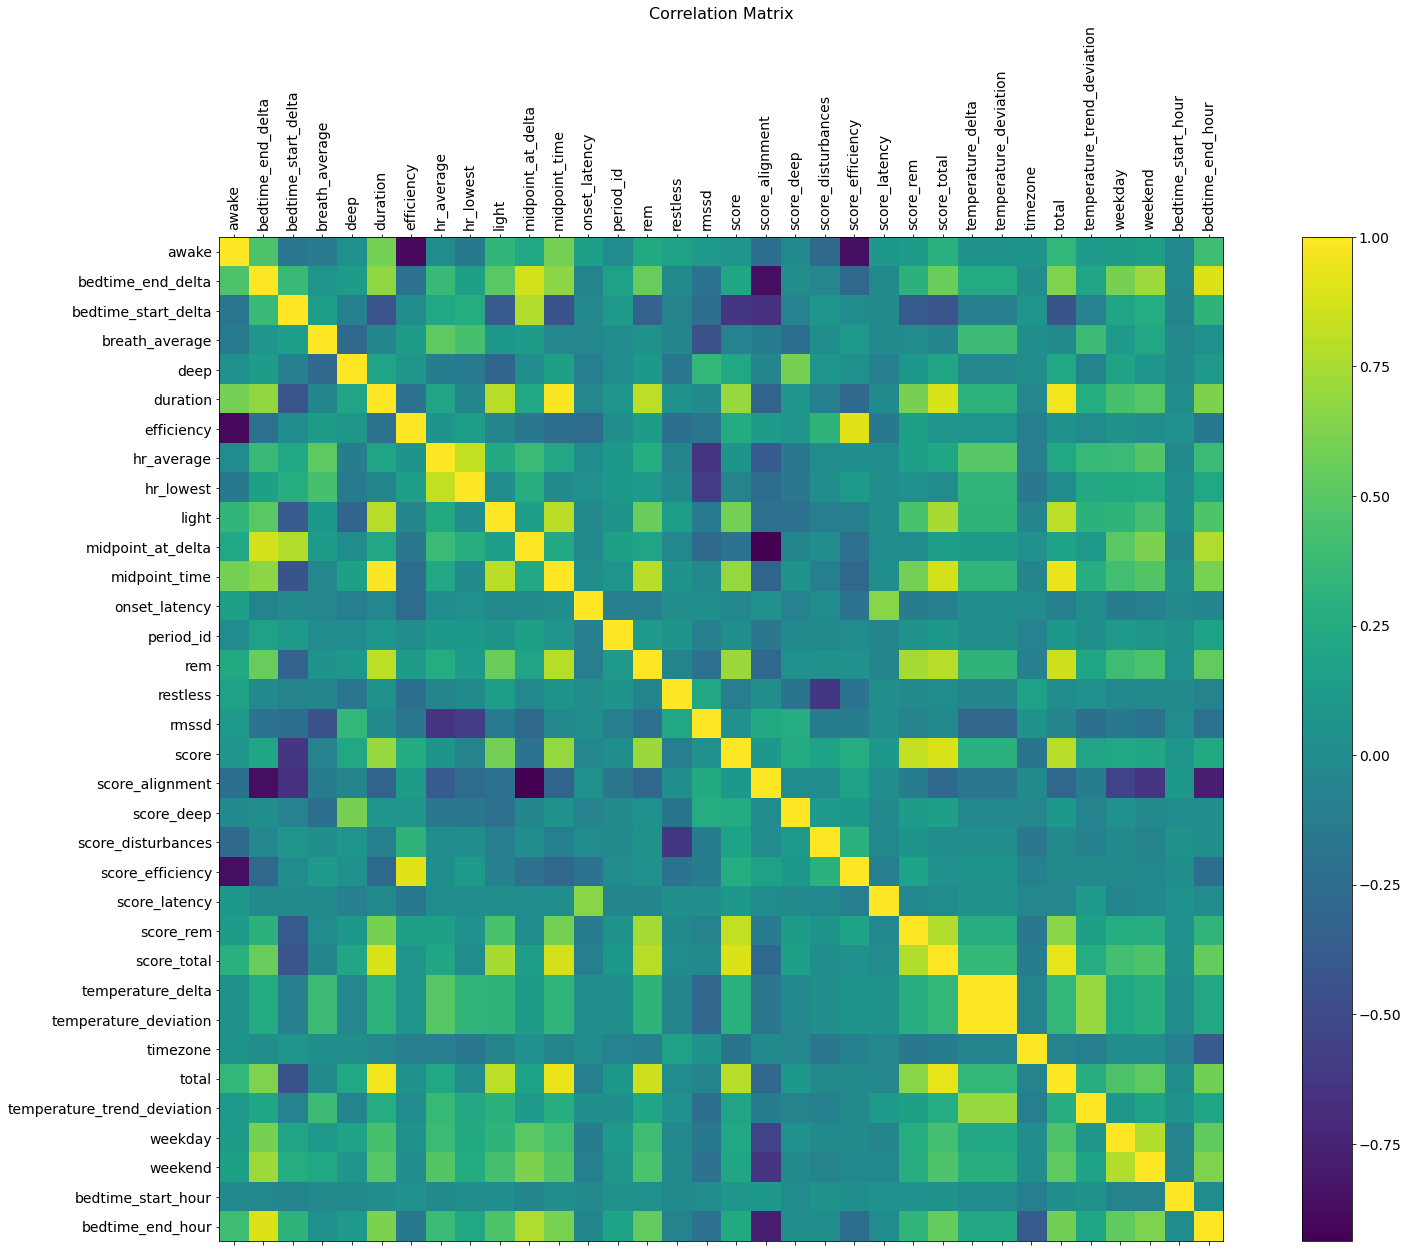

In [6]:
# Here's another way (Create a plot)
f = plt.figure(figsize=(28, 18))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


In [7]:
# Or, just check one column and print all matches
corr = df.corr()['score'].sort_values()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corr)

bedtime_start_delta           -0.632276
midpoint_at_delta             -0.200545
timezone                      -0.185122
restless                      -0.106189
breath_average                -0.079967
hr_lowest                     -0.073732
onset_latency                 -0.042528
period_id                      0.028542
rmssd                          0.041672
hr_average                     0.068408
awake                          0.072425
bedtime_start_hour             0.088548
score_alignment                0.093969
score_latency                  0.094400
score_disturbances             0.183497
temperature_trend_deviation    0.196897
bedtime_end_delta              0.204358
weekend                        0.212286
deep                           0.218609
weekday                        0.219646
bedtime_end_hour               0.240686
score_deep                     0.251285
efficiency                     0.255832
score_efficiency               0.262852
temperature_delta              0.299754


# Do my previous days metrics effect my next days sleep score?

In [15]:
df_next = df['score'] # Create another subset of data to compare
df_next = df_next.shift(periods=-1, axis=0, fill_value=0) # Shift back by one (compare days data with next days score)
df = df.join(df_next, rsuffix="_next") # Join to original df with a new name

datetime_naive
2020-08-19    78
2020-08-20    76
2020-08-21    87
2020-08-22    81
2020-08-23    73
Name: score, dtype: int64

In [9]:
# Here is the fast and easy way to plot correlations
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_10240/3870308080.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,awake,bedtime_end_delta,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_average,hr_lowest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,weekday,weekend,bedtime_start_hour,bedtime_end_hour,score_next
awake,1.00,0.46,-0.18,-0.14,0.04,0.59,-0.89,0.01,-0.15,0.34,0.22,0.60,0.16,0.01,0.24,0.17,0.11,0.07,-0.23,-0.01,-0.27,-0.86,0.10,0.13,0.29,0.06,0.06,0.06,0.35,0.10,0.13,0.16,-0.03,0.40,-0.01
bedtime_end_delta,0.46,1.00,0.38,0.07,0.12,0.68,-0.22,0.38,0.17,0.50,0.87,0.66,-0.06,0.17,0.55,-0.01,-0.20,0.20,-0.87,0.02,-0.04,-0.29,-0.02,0.31,0.56,0.24,0.24,0.02,0.63,0.21,0.60,0.72,-0.03,0.90,-0.07
bedtime_start_delta,-0.18,0.38,1.00,0.15,-0.09,-0.43,0.01,0.21,0.26,-0.38,0.78,-0.43,-0.03,0.11,-0.33,-0.07,-0.23,-0.63,-0.67,-0.08,0.08,-0.00,-0.01,-0.38,-0.43,-0.09,-0.09,0.08,-0.44,-0.08,0.20,0.26,-0.06,0.32,-0.08
breath_average,-0.14,0.07,0.15,1.00,-0.28,-0.05,0.13,0.52,0.44,0.10,0.13,-0.04,-0.04,-0.00,0.06,-0.06,-0.45,-0.08,-0.12,-0.23,0.03,0.11,-0.02,-0.00,-0.04,0.39,0.39,0.03,-0.01,0.39,0.11,0.23,-0.03,0.04,-0.04
deep,0.04,0.12,-0.09,-0.28,1.00,0.20,0.09,-0.12,-0.14,-0.31,0.01,0.16,-0.10,-0.00,0.10,-0.18,0.35,0.22,-0.05,0.60,0.08,0.04,-0.10,0.09,0.21,-0.04,-0.04,0.02,0.22,-0.06,0.18,0.08,-0.01,0.10,0.01
duration,0.59,0.68,-0.43,-0.05,0.20,1.00,-0.21,0.20,-0.05,0.79,0.23,0.99,-0.04,0.08,0.80,0.05,-0.02,0.70,-0.31,0.08,-0.10,-0.28,-0.01,0.60,0.88,0.31,0.31,-0.04,0.96,0.27,0.43,0.49,0.01,0.62,0.00
efficiency,-0.89,-0.22,0.01,0.13,0.09,-0.21,1.00,0.07,0.14,-0.05,-0.16,-0.24,-0.26,0.02,0.13,-0.23,-0.17,0.26,0.13,0.07,0.32,0.91,-0.16,0.16,0.07,0.07,0.07,-0.11,0.05,-0.00,0.05,0.01,0.04,-0.16,0.01
hr_average,0.01,0.38,0.21,0.52,-0.12,0.20,0.07,1.00,0.82,0.24,0.39,0.22,0.00,0.09,0.26,-0.06,-0.65,0.07,-0.38,-0.16,-0.00,0.02,0.00,0.16,0.21,0.50,0.50,-0.11,0.23,0.36,0.38,0.48,-0.01,0.38,0.02
hr_lowest,-0.15,0.17,0.26,0.44,-0.14,-0.05,0.14,0.82,1.00,0.01,0.27,-0.02,0.03,0.10,0.10,-0.01,-0.59,-0.07,-0.25,-0.17,0.02,0.10,0.02,0.04,-0.00,0.33,0.33,-0.16,-0.00,0.23,0.24,0.26,0.02,0.23,0.03
light,0.34,0.50,-0.38,0.10,-0.31,0.79,-0.05,0.24,0.01,1.00,0.15,0.80,-0.03,0.07,0.57,0.14,-0.14,0.60,-0.21,-0.22,-0.11,-0.09,0.02,0.45,0.75,0.33,0.33,-0.06,0.81,0.31,0.32,0.43,0.03,0.46,0.01


# Does my daily activity effect my next night's sleep score?

In [10]:
full_activity_df = pd.DataFrame.from_dict(data['activity'])
# Index by summary_date aka day when activity period started, 4AM
full_activity_df['datetime'] = pd.to_datetime(full_activity_df['summary_date']).dt.normalize()
full_activity_df.head()
full_activity_df = full_activity_df.set_index('datetime')
full_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2020-08-18 to 2022-01-07
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_met               504 non-null    float64
 1   cal_active                504 non-null    int64  
 2   cal_total                 504 non-null    int64  
 3   class_5min                504 non-null    object 
 4   daily_movement            504 non-null    int64  
 5   day_end                   504 non-null    object 
 6   day_start                 504 non-null    object 
 7   high                      504 non-null    int64  
 8   inactive                  504 non-null    int64  
 9   inactivity_alerts         504 non-null    int64  
 10  low                       504 non-null    int64  
 11  medium                    504 non-null    int64  
 12  met_1min                  504 non-null    object 
 13  met_min_high              504 non-null    int6

# Join activity with sleep score

In [11]:
df_next = df['score'] # Create another subset of data to compare
df_next = df_next.shift(periods=-1, axis=0, fill_value=0) # Shift back by one (compare days data with next days score)
full_activity_df = full_activity_df.join(df_next, lsuffix='_activity', rsuffix='_sleep') # Join to original df with a new name

# Cleanup the data a bit by dropping NaN and 0 values
full_activity_df = full_activity_df.dropna(subset=['score_sleep'])

full_activity_df.head()



,average_met,cal_active,cal_total,class_5min,daily_movement,day_end,day_start,high,inactive,inactivity_alerts,...,summary_date,target_calories,target_km,target_miles,timezone,to_target_km,to_target_miles,total,rest_mode_state,score_sleep
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-19,1.50000,509,2621,1111111111111111111111122332222222222223322222...,7929,2020-08-20T03:59:59+03:00,2020-08-19T04:00:00+03:00,31,811,1,...,2020-08-19,300,6.0,3.728226,180,-3.9,-2.423347,221,NaN,78.0
2020-08-20,1.46875,376,2525,1111111111111111111111122233222222222233333222...,5886,2020-08-21T03:59:59+03:00,2020-08-20T04:00:00+03:00,19,851,2,...,2020-08-20,450,9.0,5.592339,180,1.5,0.932057,207,NaN,76.0
2020-08-21,1.37500,263,2388,1111111111111111111111122233222222222222333322...,4249,2020-08-22T03:59:59+03:00,2020-08-21T04:00:00+03:00,8,833,2,...,2020-08-21,450,9.0,5.592339,180,3.7,2.299073,171,NaN,87.0
2020-08-22,1.28125,214,2242,1111111111111111111111111111111111111111112223...,4156,2020-08-23T03:59:59+03:00,2020-08-22T04:00:00+03:00,0,620,1,...,2020-08-22,450,9.0,5.592339,180,4.7,2.920444,207,NaN,81.0
2020-08-23,1.21875,137,2147,1111111111111111111111111111111111111111112233...,2412,2020-08-24T03:59:59+03:00,2020-08-23T04:00:00+03:00,0,525,1,...,2020-08-23,450,9.0,5.592339,180,6.2,3.852500,164,NaN,73.0


In [12]:
#corr = full_activity_df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)


corr = full_activity_df.corr()['score_sleep'].sort_values()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corr)


inactivity_alerts          -0.228648
score_meet_daily_targets   -0.176195
high                       -0.144201
met_min_high               -0.142457
timezone                   -0.138509
score_training_volume      -0.131180
score_training_frequency   -0.120894
average_met                -0.120347
daily_movement             -0.118415
cal_active                 -0.103285
inactive                   -0.088068
score_activity             -0.085842
met_min_medium             -0.001942
steps                      -0.001700
non_wear                    0.000162
medium                      0.004790
cal_total                   0.012674
rest_mode_state             0.036164
score_recovery_time         0.073219
total                       0.096146
met_min_low                 0.103738
target_km                   0.120219
target_miles                0.120219
target_calories             0.135230
to_target_km                0.142746
to_target_miles             0.142746
low                         0.151778
m